In [23]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

In [24]:
path = Path('.')
df = pd.read_csv(path/'training_data_v2.csv', delimiter=',', engine='python',
                     header=0)

In [25]:
df.head()

,date,morning_temp,morning_wind,morning_humidity,morning_rain,morning_cloud,noon_temp,noon_wind,noon_humidity,noon_rain,noon_cloud,afternoon_temp,afternoon_wind,afternoon_humidity,afternoon_rain,afternoon_cloud,daily_power
0,2012-01-01,11.846154,19.384615,90.769231,no rain,overcast clouds,12.900000,19.000000,88.600000,no rain,overcast clouds,13.076923,27.000000,87.538462,rain,overcast clouds,5.6
1,2012-01-02,8.071429,15.214286,84.285714,no rain,broken clouds,8.555556,19.333333,79.333333,no rain,broken clouds,6.071429,17.285714,76.214286,no rain,clear sky,2.5
2,2012-01-03,6.857143,32.500000,80.428571,no rain,few clouds,10.700000,43.100000,82.200000,rain,few clouds,9.642857,32.071429,74.071429,no rain,broken clouds,7.6
3,2012-01-04,7.000000,28.714286,67.785714,no rain,broken clouds,7.700000,25.200000,67.500000,no rain,broken clouds,7.785714,26.142857,76.357143,no rain,broken clouds,15.1
4,2012-01-05,9.384615,40.230769,81.461538,rain,broken clouds,8.777778,41.111111,69.888889,no rain,broken clouds,6.444444,38.333333,73.777778,no rain,broken clouds,13.1


In [26]:
df['noon_cloud'].unique()

array(['overcast clouds', 'broken clouds', 'few clouds',
       'scattered clouds', 'clear sky'], dtype=object)

/home/nhat/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


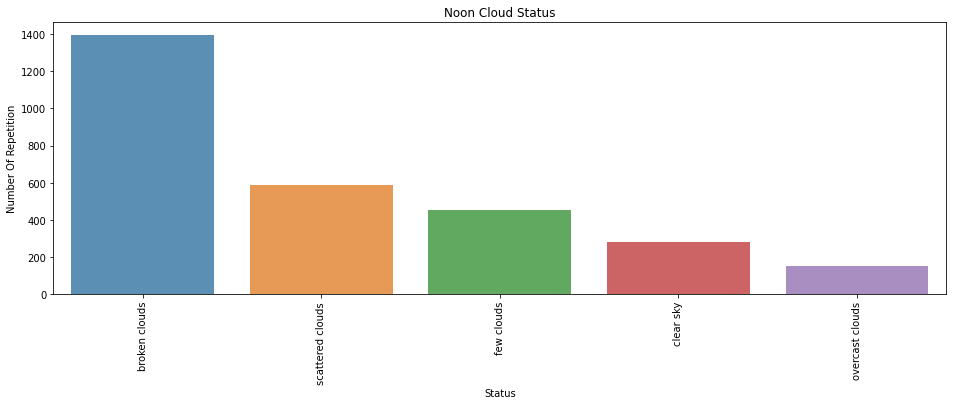

In [27]:
import seaborn as sns
weather_counts = df['noon_cloud'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Noon Cloud Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [28]:
df['noon_rain'].unique()

array(['no rain', 'rain', 'snow', 'drizzle'], dtype=object)

'rain' can be seen as pure caregorical data since they cannot be put into a suitable ordering. However, 'cloud' in this case is ordinal columns. According to the document of OpenWeather API, the order is as follow:

In [29]:
cloud_levels = 'overcast clouds', 'broken clouds', 'scattered clouds', 'few clouds', 'clear sky'
#cloud_levels = 'Overcast', 'Cloudy', 'Mostly cloudy', 'Haze', 'Ice Fog', 'Fog', 'Broken clouds', 'More clouds than sun', 'Passing clouds', 'Scattered clouds', 'Low clouds', 'Partly sunny', 'Clear', 'Sunny'

In [30]:
df.isna().sum()

date                  0
morning_temp          0
morning_wind          0
morning_humidity      0
morning_rain          0
morning_cloud         0
noon_temp             0
noon_wind             0
noon_humidity         0
noon_rain             0
noon_cloud            0
afternoon_temp        0
afternoon_wind        0
afternoon_humidity    0
afternoon_rain        0
afternoon_cloud       0
daily_power           0
dtype: int64

In [9]:
df['morning_cloud'] = df['morning_cloud'].astype('category')
df['noon_cloud'] = df['noon_cloud'].astype('category')
df['afternoon_cloud'] = df['afternoon_cloud'].astype('category')
df['morning_cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)
df['noon_cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)
df['afternoon_cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)

Date is useless in predicting the energy production, so we can drop it out

In [31]:
df.drop(['date', 'morning_cloud', 'morning_rain', 'noon_cloud', 'noon_rain', 'afternoon_cloud', 'afternoon_rain'], axis=1, inplace=True)

df.head()

,morning_temp,morning_wind,morning_humidity,noon_temp,noon_wind,noon_humidity,afternoon_temp,afternoon_wind,afternoon_humidity,daily_power
0,11.846154,19.384615,90.769231,12.900000,19.000000,88.600000,13.076923,27.000000,87.538462,5.6
1,8.071429,15.214286,84.285714,8.555556,19.333333,79.333333,6.071429,17.285714,76.214286,2.5
2,6.857143,32.500000,80.428571,10.700000,43.100000,82.200000,9.642857,32.071429,74.071429,7.6
3,7.000000,28.714286,67.785714,7.700000,25.200000,67.500000,7.785714,26.142857,76.357143,15.1
4,9.384615,40.230769,81.461538,8.777778,41.111111,69.888889,6.444444,38.333333,73.777778,13.1


fastai determines which columns should be treated as categorical variables by comparing the number of distinct levels in the variable to the value of the max_card variable:

In [32]:
#df.drop(labels=['cloud', 'rain'], axis=1, inplace=True)
cont_df,cat_df = cont_cat_split(df, max_card = 15, dep_var = 'daily_power')

In [33]:
df[cat_df].nunique()

Series([], dtype: float64)

The data must be normalized before being fed to the neural network:

In [59]:
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(0.3)(range_of(df))
to_nn = TabularPandas(df, procs_nn, cat_df, cont_df, splits=splits, y_names='daily_power')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   morning_temp        2863 non-null   float64
 1   morning_wind        2863 non-null   float64
 2   morning_humidity    2863 non-null   float64
 3   noon_temp           2863 non-null   float64
 4   noon_wind           2863 non-null   float64
 5   noon_humidity       2863 non-null   float64
 6   afternoon_temp      2863 non-null   float64
 7   afternoon_wind      2863 non-null   float64
 8   afternoon_humidity  2863 non-null   float64
 9   daily_power         2863 non-null   float64
dtypes: float64(10)
memory usage: 223.8 KB


In [73]:
dls = to_nn.dataloaders(150)

In [74]:
y = to_nn.train.y
y.min(), y.max()

(0.0, 34.0)

In [75]:
from fastai.tabular.all import*

In [79]:
learn = tabular_learner(dls, layers=[1000,500], y_range=(-0.2, 34.5), n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.00010964782268274575)

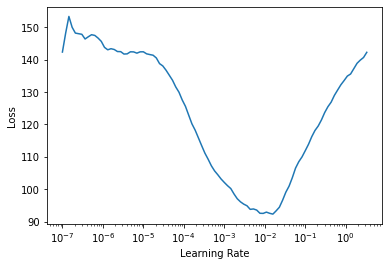

In [80]:
learn.lr_find()

In [81]:
learn.fine_tune(17, 1e-2)

epoch,train_loss,valid_loss,time
0,91.972519,94.659691,00:00


epoch,train_loss,valid_loss,time
0,84.716362,70.139275,00:00
1,73.872581,63.764160,00:00
2,68.905998,61.199257,00:00
3,63.454517,53.104881,00:00
4,59.066650,49.176636,00:00
5,59.460918,72.445625,00:00
6,60.686157,63.697353,00:00
7,60.137672,55.747795,00:00
8,58.553814,52.252396,00:00
9,56.270573,55.559013,00:00


In [82]:
preds,targs = learn.get_preds()

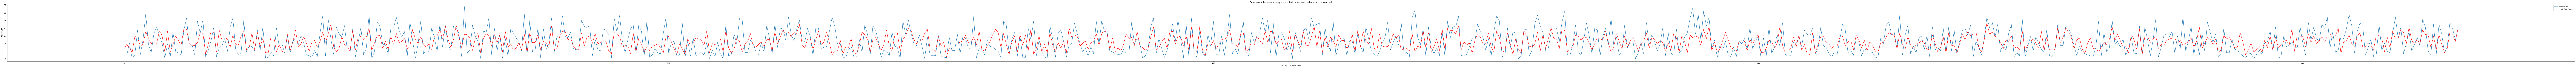

In [83]:
plt.figure(figsize=(260,6))
plt.plot(range(len(targs)), targs)
plt.plot(range(len(preds)), preds, 'r')
plt.title('Comparison between average predicted values and real ones in the valid set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Valid Data')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()